<a href="https://colab.research.google.com/github/epadam/Machine-Learning-Tutorial-Demo-Resources/blob/master/notebooks/cv/Saliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os 
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [128]:
def preprocess(img, size=(224, 224)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)


def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [16]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [40]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = '/content/imagenet_val_25.npz'
    if not os.path.isfile(imagenet_fn):
      print('file %s not found' % imagenet_fn)
      print('Run the following:')
      print('cd cs231n/datasets')
      print('bash get_imagenet_val.sh')
      assert False, 'Need to download imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle = True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

In [111]:
image = Image.open('/content/n01443537_goldfish.jpg')
image = preprocess(image)
data = asarray(image)

data = torch.from_numpy(data)

In [112]:
model.eval()
predict = model.forward(data)
predict.argmax()

tensor(1)

In [129]:
from PIL import Image
from numpy import asarray
import glob
# load the image
X= []
files = glob.glob ("*.jpg")
for myFile in files:
    image = Image.open(myFile)
    image = preprocess(image)
    data = asarray(image)
    print(myFile)
    X.append (data)



n01491361_tiger_shark.jpg
n01514668_cock.jpg
n01443537_goldfish.jpg
n01518878_ostrich.jpg
n01440764_tench.jpg


In [134]:
X = np.array(X)

In [137]:
X = X.reshape(5, 3, 224, 224)

Exception ignored in: <function NpzFile.__del__ at 0x7fb36d7948c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
Exception ignored in: <function NpzFile.__del__ at 0x7fb36d7948c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


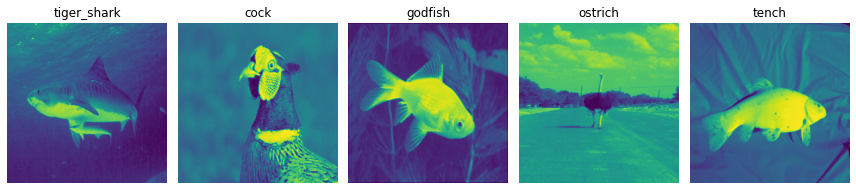

In [140]:
#X, y, class_names = load_imagenet_val(num=5)

y = [3, 86, 1, 9, 0]

class_names = ['tiger_shark', 'cock', 'godfish', 'ostrich', 'tench']

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i][0])
    plt.title(class_names[i])
    plt.axis('off')
plt.gcf().tight_layout()

In [ ]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())


gather_example()

In [ ]:
torch.LongTensor(y).view(-1,1)

In [141]:
def compute_saliency_maps(X, y, model):
    """
    X表示图片, y表示分类结果, model表示使用的分类模型
    
    Input : 
    - X : Input images : Tensor of shape (N, 3, H, W)
    - y : Label for X : LongTensor of shape (N,)
    - model : A pretrained CNN that will be used to computer the saliency map
    
    Return :
    - saliency : A Tensor of shape (N, H, W) giving the saliency maps for the input images
    """
    # 确保model是test模式
    model.eval()
    
    # 确保X是需要gradient
    X.requires_grad_()
    
    saliency = None
    
    logits = model.forward(X)
    logits = logits.gather(1, y.view(-1, 1)).squeeze() # 得到正确分类
    logits.backward(torch.FloatTensor([1., 1., 1., 1., 1.])) # 只计算正确分类部分的loss
    
    saliency = abs(X.grad.data) # 返回X的梯度绝对值大小
    saliency, _ = torch.max(saliency, dim=1)
    
    return saliency.squeeze()

In [142]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


show_saliency_maps(X, y)

TypeError: ignored